## NREL National Solar Radiation Database (NSRDB) - Local HDF5 Demo

## NREL HPC Environment Preparation (Kestrel)

### JupyterHub (kestrel-jhub)
To run this notebook on NREL's HPC, you will need use the Jupyterhub interface. You can access the Jupyterhub interface by going to the following URL: https://kestrel-jhub.hpc.nrel.gov and login with your NREL HPC username and password.

The default work directory is your `$HOME` directory on Eagle. You need to create symbolic link to `/vast/datasets` in your `$HOME` directory. You can do this by running the following command in your `$HOME` directory:

```bash
ln -s /kfs2/datasets ~/datasets
```
**Note: User home directory as local root directory in Jupyterhub is not working as expected on kestrel-jhub unlike on Europa for Eagle. Examples will be pointing to files at absolute path in /kfs2**

### VS Code and HPC Compute Node
It is a good practice to do your jobs on a compute node rather than login (head) node in HPC environment. VS Code has the ability to directly connect to a remote server, utilize the Python interpreter, while keeping the visualization and control of Jupyter Notebook locally.

To do that, we need to first submit a SSH tunel daemon listening to incoming commands. This can be done by submitting thejob defined as the sbatch script below.
```bash
#!/bin/bash

#SBATCH --job-name="tunnel"
#SBATCH --time=2:00:00     # walltime
#SBATCH --partition=short
#SBATCH --account=cscdav

/usr/sbin/sshd -D -p 2222 -f /dev/null -h ${HOME}/.ssh/id_rsa # uses the user key as the host key
#Change the private key
```

Submit the job with `sbatch` command. Assume the sbatch script is saved in a text file `tunnel.sbatch`, submit by `sbatch ./tunnel.sbatch`.

Once job is submitted, monitor it using `squeue` command.
```
> squeue --me
    JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
    14272639     short   tunnel     fhsu  R      13:22      1 r5i2n15
```

If the job is running, the daemon is ready on the compute node assigned.

Now we need to edit the SSH config on our local machine.
Append following config the the end of `~/.ssh/config`
```
Host compute-node
    ProxyCommand ssh -o 'ForwardAgent yes' kestrel.hpc.nrel.gov "ssh-add && nc \$(squeue --me --name=tunnel --states=R -h -O NodeList) 2222"
    StrictHostKeyChecking no
```

Make sure the public key exists as `~/.ssh/id_rsa.pub`. If not, run `ssh-keygen -t rsa` to create a public key. If you already have an RSA key pair setup, skip this step.

Now we should be able to ssh to the compute node with `ssh compute-node`. To connect VS Code to the compute node, use the `Remote - SSH` extension. Then add new SSH connection, click on the extension icon. In the list of SSH remotes, click the `+` icon next to SSH folder. When prompted, enter `ssh compute-node` in the command field. Now we can connect to the running compute node using VS Code.



## Python Environment Preparation
This notebook demonstrates basic usage of the National Renewable Energy Laboratory (NREL) National Solar Radiation Database (NSRDB) data. The data is provided from Amazon Web Services using the HDF Group's Highly Scalable Data Service (HSDS). In this document, the data is accessed from local storage, which are available on NREL HPC storage in `/kfs2/datasets/NSRDB`.

To prepare Python environment for two different use cases, follow respective steps below.

### JupyterHub (kestrel-jhub)
If you are running this notebook on `kestrel-jhub` jupyterhub server (kestrel-jh.hpc.nrel.gov), follow steps below to start a virtual environment with kernel for Jupyter.
In launcher tab, select Terminal.
```
> module load anaconda3
> conda create --name nsrdb
> conda activate nsrdb
(nsrdb) > conda install python
(nsrdb) > pip install h5py
(nsrdb) > pip install numpy
(nsrdb) > pip install matplotlib
(nsrdb) > pip install pandas
(nsrdb) > pip install scipy
(nsrdb) > pip install ipykernel
(nsrdb) > python -m ipykernel install --user --name nsrdb --display-name "Python (nsrdb)"
```
Now you should be able to select kernel shown as `Python (nsrdb)` from the notebook tab or `Change Kernel` in the `Kernel` menu.

### VS Code and HPC Compute Node
You will need Python and Jupyter extention in VS Code to run Jupyter Notebook in VS Code.


**Note: You may be prompted in extention install options to install Jupyter extension for SSH:compute-node. This will allow kernel detection in the remote session**


If you are running this notebook on a compute node in NREL HPC, remember to create an environment to install these packages.
```
> modulle load anaconda3
> conda create --name nsrdb
> conda activate nsrdb
(nsrdb) > conda install python
(nsrdb) > pip install h5py
(nsrdb) > pip install numpy
(nsrdb) > pip install matplotlib
(nsrdb) > pip install pandas
(nsrdb) > pip install scipy
(nsrdb) > python -m ipykernel install --user --name nsrdb --display-name "Python (nsrdb)"
```
Now you should be able to select `Python (nsrdb)` kernel from dropdown list by clicking the `Select Kernel` button in the upper right corner of the notebook tab.

**This notebook is forked from NREL NSRDB Instroduction Python notebook by NREL. The original notebook can be found [here](https://github.com/NREL/hsds-examples/blob/master/notebooks/03_NSRDB_introduction.ipynb).**


**The original notebook demonstrates how to access the NSRDB data using the HDF Group's Highly Scalable Data Service (HSDS) and provides some basic examples of how to work with the data. This notebook is modified to work with HSRDB HDF5 files saved at local storage.**

In [36]:
%matplotlib inline
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.spatial import cKDTree

## Basic Usage

The NSRDB is provided in annual .h5 files and currently spans 1998-2022.  
Each year can be accessed from /datasets/NSRDB/current/nsrdb_${year}.h5 for CONUS data.

In [37]:
# Open the desired year of nsrdb data

f=h5py.File("/kfs2/datasets/NSRDB/current/nsrdb_2022.h5", 'r')

In [38]:
list(f.attrs)  # list attributes belonging to the root group

['full_version_record', 'package', 'version']

In [39]:
# f.attrs['version']   # attributes can be used to provide desriptions of the content
# There is no attributes in this file.

## Datasets

In [40]:
list(f)  # list the datasets in the file

['air_temperature',
 'alpha',
 'aod',
 'asymmetry',
 'cld_opd_dcomp',
 'cld_press_acha',
 'cld_reff_dcomp',
 'clearsky_dhi',
 'clearsky_dni',
 'clearsky_ghi',
 'cloud_fill_flag',
 'cloud_type',
 'dew_point',
 'dhi',
 'dni',
 'fill_flag',
 'ghi',
 'meta',
 'ozone',
 'relative_humidity',
 'solar_zenith_angle',
 'ssa',
 'surface_albedo',
 'surface_pressure',
 'time_index',
 'total_precipitable_water',
 'wind_direction',
 'wind_speed']

In [41]:
# Datasets are stored in a 2d array of time x location
dset = f['ghi']
dset.shape

(17520, 2018267)

In [42]:
# Extract datetime index for datasets
time_index = pd.to_datetime(f['time_index'][...].astype(str))
time_index # Temporal resolution is 30min

DatetimeIndex(['2022-01-01 00:00:00+00:00', '2022-01-01 00:30:00+00:00',
               '2022-01-01 01:00:00+00:00', '2022-01-01 01:30:00+00:00',
               '2022-01-01 02:00:00+00:00', '2022-01-01 02:30:00+00:00',
               '2022-01-01 03:00:00+00:00', '2022-01-01 03:30:00+00:00',
               '2022-01-01 04:00:00+00:00', '2022-01-01 04:30:00+00:00',
               ...
               '2022-12-31 19:00:00+00:00', '2022-12-31 19:30:00+00:00',
               '2022-12-31 20:00:00+00:00', '2022-12-31 20:30:00+00:00',
               '2022-12-31 21:00:00+00:00', '2022-12-31 21:30:00+00:00',
               '2022-12-31 22:00:00+00:00', '2022-12-31 22:30:00+00:00',
               '2022-12-31 23:00:00+00:00', '2022-12-31 23:30:00+00:00'],
              dtype='datetime64[ns, UTC]', length=17520, freq=None)

In [43]:
# Locational information is stored in either 'meta' or 'coordinates'
meta = pd.DataFrame(f['meta'][...])
meta.head()

,latitude,longitude,elevation,timezone,country,state,county
0,-15.950000,-179.979996,0,12,b'nan',b'nan',b'nan'
1,-15.990000,-179.979996,0,12,b'nan',b'nan',b'nan'
2,-16.030001,-179.979996,0,12,b'nan',b'nan',b'nan'
3,-16.070000,-179.979996,0,12,b'nan',b'nan',b'nan'
4,-16.110001,-179.979996,0,12,b'nan',b'nan',b'nan'


In [44]:
# Datasets have been saved as integers
dset.dtype

dtype('uint16')

In [45]:
dset.shape[0] * dset.shape[1] * 2 * 10**-9 # 70 GB per dataset!

70.72007568000001

In [46]:
dset.chunks # Chunked by week

(2000, 500)

In [47]:
dset.chunks[0] * dset.chunks[1] * 2 * 10**-6 # 2 MB per chunk

2.0

In [48]:
# To convert dataset values back to floats use the 'psm_scale_factor'
dset.attrs['scale_factor'] # Irradiance values have been truncated to integer precision

1.0

In [49]:
# wind speed on the other hand has single decimal percision when scaled by 10
scale_factor = f['wind_speed'].attrs['psm_scale_factor']
units = f['wind_speed'].attrs['psm_units']
print('wind_speed scale factor = ', scale_factor)
print('wind_speed units after unscaling = ', units)
f['wind_speed'][0, 0] / scale_factor # divide by scale_factor to return native value

wind_speed scale factor =  10.0
wind_speed units after unscaling =  m/s


2.7

## Time-slicing

Get the time_index from the server and convert to a pandas DatetimeIndex for convenience:

In [50]:
time_index = pd.to_datetime(f['time_index'][...].astype(str))
time_index

DatetimeIndex(['2022-01-01 00:00:00+00:00', '2022-01-01 00:30:00+00:00',
               '2022-01-01 01:00:00+00:00', '2022-01-01 01:30:00+00:00',
               '2022-01-01 02:00:00+00:00', '2022-01-01 02:30:00+00:00',
               '2022-01-01 03:00:00+00:00', '2022-01-01 03:30:00+00:00',
               '2022-01-01 04:00:00+00:00', '2022-01-01 04:30:00+00:00',
               ...
               '2022-12-31 19:00:00+00:00', '2022-12-31 19:30:00+00:00',
               '2022-12-31 20:00:00+00:00', '2022-12-31 20:30:00+00:00',
               '2022-12-31 21:00:00+00:00', '2022-12-31 21:30:00+00:00',
               '2022-12-31 22:00:00+00:00', '2022-12-31 22:30:00+00:00',
               '2022-12-31 23:00:00+00:00', '2022-12-31 23:30:00+00:00'],
              dtype='datetime64[ns, UTC]', length=17520, freq=None)

Extract indexes for a particular span of time:

In [51]:
march = time_index.month == 3
np.where(march)[0]

array([2832, 2833, 2834, ..., 4317, 4318, 4319])

Or a particular date:

In [52]:
timestep = np.where(time_index == '2022-07-04 00:00:00')[0][0]
timestep

8832

## Map Data

In [53]:
# Extract coordinates (lat, lon)
coords = np.array([f['meta']['latitude'],f['meta']['longitude']]).transpose()

In [54]:
dset = f['ghi']
%time data = dset[timestep, ::10]   # extract every 10th location at a particular time
df = pd.DataFrame() # Combine data with coordinates in a DataFrame
df['longitude'] = coords[::10, 1]
df['latitude'] = coords[::10, 0]
df['ghi'] = data / dset.attrs['scale_factor'] # unscale dataset

CPU times: user 13.7 ms, sys: 54.7 s, total: 54.7 s
Wall time: 12min 56s


In [55]:
df.shape

(201827, 3)

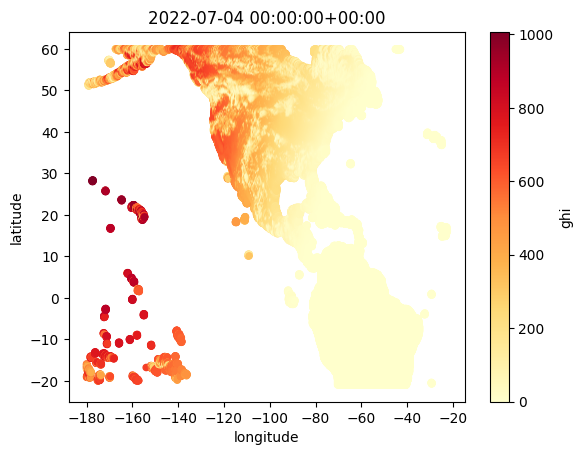

In [56]:
df.plot.scatter(x='longitude', y='latitude', c='ghi',
                colormap='YlOrRd',
                title=str(time_index[timestep]))
plt.show()

In [57]:
# Full resolution subset of California
meta = pd.DataFrame(f['meta'][...])
CA = meta.loc[meta['state'] == b'California'] # Note .h5 saves strings as bit-strings
CA.head()

,latitude,longitude,elevation,timezone,country,state,county
110930,40.490002,-124.379997,158,-8,b'United States',b'California',b'Humboldt'
110931,40.450001,-124.379997,160,-8,b'United States',b'California',b'Humboldt'
110932,40.410000,-124.379997,281,-8,b'United States',b'California',b'Humboldt'
111362,40.570000,-124.339996,60,-8,b'United States',b'California',b'Humboldt'
111363,40.529999,-124.339996,201,-8,b'United States',b'California',b'Humboldt'


In [58]:
%time data = dset[timestep][CA.index]  # full-resolution subset
df = CA[['longitude', 'latitude']].copy()
df['ghi'] = data / dset.attrs['psm_scale_factor']
df.shape

CPU times: user 45.3 ms, sys: 13.6 s, total: 13.6 s
Wall time: 4min 42s


(25981, 3)

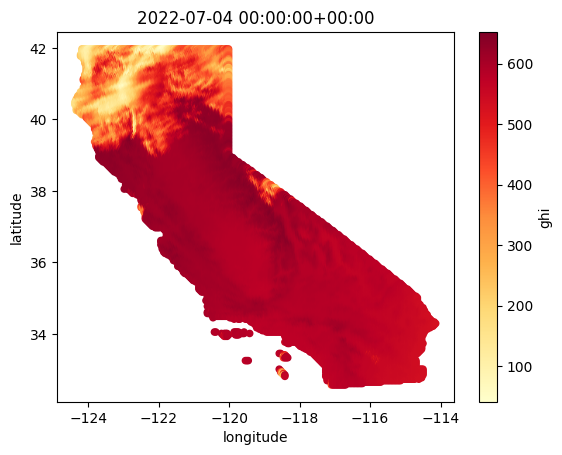

In [59]:
df.plot.scatter(x='longitude', y='latitude', c='ghi',
                colormap='YlOrRd',
                title=str(time_index[timestep]))
plt.show()

## Nearest Timeseries for given Lat/Lon

In [60]:
# Unlike the gridded WTK data the NSRDB is provided as sparse time-series dataset.
# The quickest way to find the nearest site it using a KDtree

# dset_coords = f['coordinates'][...]
dset_coords = np.array([f['meta']['latitude'],f['meta']['longitude']]).transpose()
tree = cKDTree(dset_coords)
def nearest_site(tree, lat_coord, lon_coord):
    lat_lon = np.array([lat_coord, lon_coord])
    dist, pos = tree.query(lat_lon)
    return pos

NewYorkCity = (40.7128, -74.0059)
NewYorkCity_idx = nearest_site(tree, NewYorkCity[0], NewYorkCity[1] )

print("Site index for New York City: \t\t {}".format(NewYorkCity_idx))
print("Coordinates of New York City: \t {}".format(NewYorkCity))
print("Coordinates of nearest point: \t {}".format(dset_coords[NewYorkCity_idx]))

Site index for New York City: 		 1243965
Coordinates of New York City: 	 (40.7128, -74.0059)
Coordinates of nearest point: 	 [ 40.73 -74.02]


In [61]:
# Get the entire 2012 timeseries data for a point in NYC
%time tseries = dset[:, NewYorkCity_idx] / dset.attrs['psm_scale_factor']

CPU times: user 3.83 ms, sys: 396 ms, total: 400 ms
Wall time: 2.39 s


In [62]:
len(tseries)   # 1 years * 365 days * 24 hours * 30 minutes

17520

Text(0.5, 1.0, 'NYC ghi in 2022')

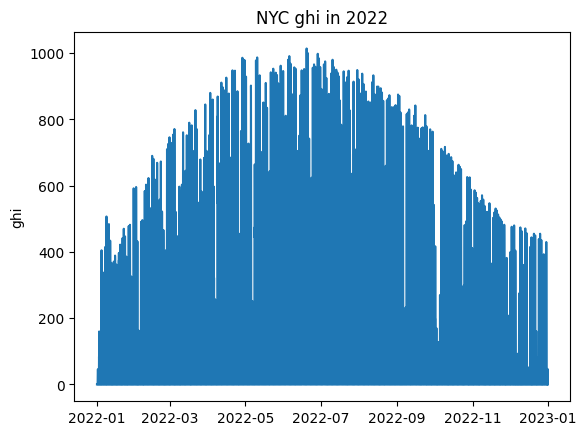

In [63]:
plt.plot(time_index, tseries)
plt.ylabel("ghi")
plt.title("NYC ghi in 2022")

## GHI Statistics

In [64]:
df = pd.DataFrame({'ghi': tseries}, index=time_index)
df["year"] = df.index.year
df["month"] = df.index.month
df["day"] = df.index.day
df["hour"] = df.index.hour

agg = df.groupby(["month","hour"]).mean()
agg = agg.reset_index().pivot(index="month",columns="hour",values="ghi")
agg

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
month,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,163.387097,237.822581,289.225806,309.419355,300.532258,236.096774,148.741935,56.177419,1.467742,0.000000
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,275.892857,379.392857,427.946429,432.928571,394.714286,354.267857,256.142857,130.285714,23.160714,0.000000
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,370.516129,439.032258,503.129032,481.725806,445.870968,391.145161,290.290323,171.048387,67.209677,3.161290
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,506.166667,589.150000,608.883333,624.983333,591.300000,499.000000,399.033333,245.966667,121.783333,25.166667
5,3.209677,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.435484,...,507.467742,576.903226,616.467742,654.161290,623.000000,541.274194,423.370968,284.419355,177.467742,67.612903
6,15.183333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.250000,...,584.133333,680.283333,722.466667,769.183333,730.083333,618.833333,491.600000,361.400000,235.450000,109.983333
7,13.387097,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.370968,...,620.112903,703.580645,769.403226,743.419355,681.564516,601.790323,499.822581,377.596774,235.096774,98.951613
8,1.387097,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,557.951613,667.790323,718.451613,704.870968,676.096774,599.709677,497.677419,354.548387,205.887097,58.161290
9,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,497.733333,578.616667,635.400000,634.666667,576.533333,483.066667,357.950000,217.133333,84.650000,5.650000


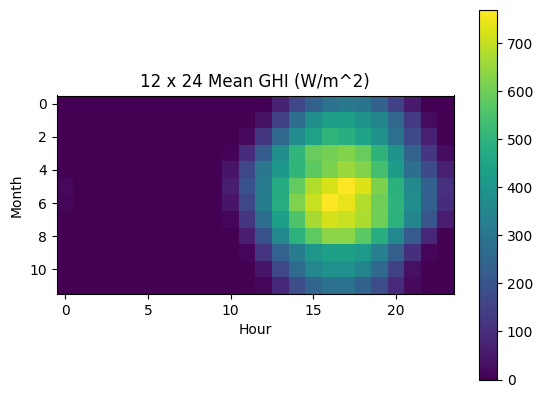

In [65]:
plt.imshow(agg)
plt.xlabel("Hour")
plt.ylabel("Month")
plt.title("12 x 24 Mean GHI (W/m^2)")
plt.colorbar()